# List of imports

In [7]:
from glob import glob
import pandas.core.common
from torch.utils.data import Dataset
import cv2
import numpy as np
from torchvision.transforms import transforms as T
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import random

# Creating lists of image paths
Creating train, valid and test sets. Train and valid sets are split 80/20.

In [8]:
train_data_path = 'data\\train'
test_data_path = 'data\\test'

classes, test_image_paths, train_image_paths = [], [], []

for data_path in glob(train_data_path + '\\*'):
    classes.append(" ".join(" - ".join(data_path.split('\\')[-1].split('___')).split('_')))
    train_image_paths.append(glob(data_path + '\\*'))
    
train_image_paths = list(pandas.core.common.flatten(train_image_paths))

for data_path in glob(test_data_path + '\\*'):
    test_image_paths.append(glob(data_path + '\\*'))

test_image_paths = list(pandas.core.common.flatten(test_image_paths))

split_index = int(len(train_image_paths) * 0.8)
random.shuffle(train_image_paths)
train_image_paths, valid_image_paths = train_image_paths[:split_index], train_image_paths[split_index:]

print('class example: ', classes[0])
print('train_image_path example: ', train_image_paths[0])
print('test_image_path example: ', test_image_paths[0], end='\n\n')

print(f'Train size: {len(train_image_paths)}')
print(f'Valid size: {len(valid_image_paths)}')
print(f'Test size: {len(test_image_paths)}')


class example:  Apple - healthy
train_image_path example:  data\train\Tomato___late_blight\757868c3-554d-4d29-bec3-fee3d8200c38___GHLB2 Leaf 9080.JPG
test_image_path example:  data\test\Apple___healthy\1001.jpg.jpeg

Train size: 38191
Valid size: 9548
Test size: 2732


### Map indexes to classes and classes to indexes

In [9]:
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key, value in idx_to_class.items()}

# Create Datasets

In [10]:
class PlantDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype(np.float32)
        image = torch.tensor(image).permute(2, 0, 1)
        
        label = " ".join(" - ".join(image_path.split('\\')[-2].split('___')).split('_'))
        index = class_to_idx[label]
        
        if self.transform:
            image = self.transform(image)
        
        return image, index

transforms = T.Compose([
    T.Resize((256, 256))
])

train_dataset = PlantDataset(train_image_paths, transforms)
valid_dataset = PlantDataset(valid_image_paths, transforms)
test_dataset = PlantDataset(test_image_paths, transforms)

# Visualize Dataset

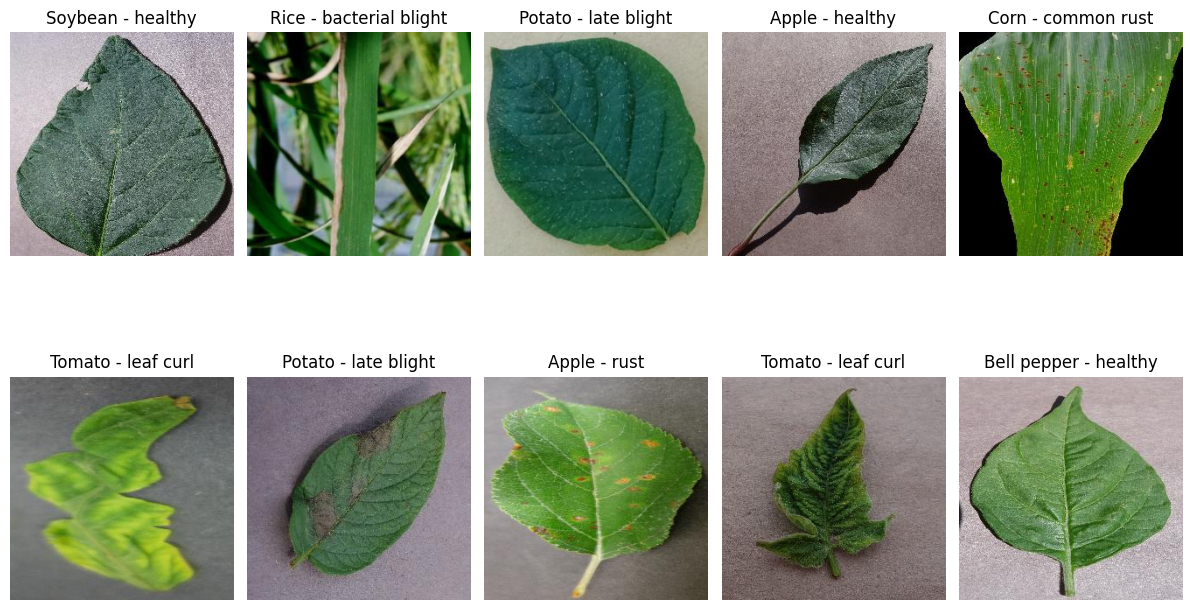

In [11]:
def visualize_augmentations(dataset, samples=10, cols=5):
    rows = samples // cols
    ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))[1]

    for i in range(samples):
        idx = np.random.randint(1,len(train_image_paths))
        image, index = dataset[idx]
        image = image.numpy().astype(np.uint8)
        
        ax.ravel()[i].imshow(np.transpose(image, (1, 2, 0)))
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[index])

    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset)

# Defining Dataloaders

In [12]:
train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=32, shuffle=True
)

test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False
)

Feature batch shape: torch.Size([32, 3, 256, 256])
Labels batch shape: torch.Size([32])


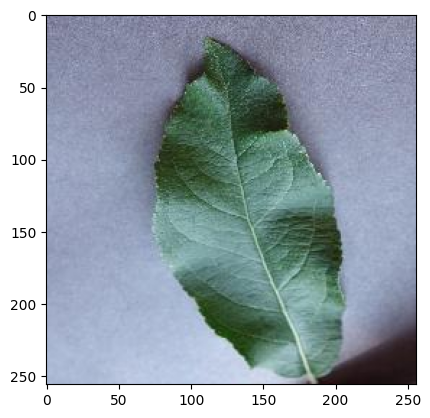

Label: Apple - healthy


In [13]:
image, index = next(iter(train_loader))
print(f"Feature batch shape: {image.size()}")
print(f"Labels batch shape: {index.size()}")
image = image[0].numpy().astype(np.uint8)
plt.imshow(np.transpose(image, (1, 2, 0)))
plt.show()
print(f"Label: {idx_to_class[index[0].item()]}")

In [14]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [15]:
class NeuralNetwork(nn.Module):
	
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.fc1 = nn.Linear(16 * 61 * 61, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 60)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 61 * 61)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [16]:
net = NeuralNetwork().to(device)
print(net)

NeuralNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=59536, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=60, bias=True)
)


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=1e-3)

In [23]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
train_losses, val_losses, train_accs, val_accs = [], [], [], []


start.record()
for epoch in range(2):

    train_loss = 0.0
    train_correct = 0 
    train_total = 0
    net.train()
    for i, train_data in enumerate(train_loader, 0):

        train_inputs, train_labels = train_data
        train_inputs, train_labels = train_inputs.to(device), train_labels.to(device)

        optimizer.zero_grad()
        outputs = net(train_inputs)
        loss = criterion(outputs, train_labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == train_labels).sum().item()

    train_loss_avg = train_loss / len(train_loader)
    train_acc = train_correct / len(train_loader.dataset)
    print(f'[{epoch + 1}, {i + 1}] Train loss: {train_loss_avg:.3f}')
    print(f'[{epoch + 1}, {i + 1}] Train acc: {train_acc:.3f}')

    valid_loss = 0.0
    valid_correct = 0 
    valid_total = 0
    net.eval()
    with torch.no_grad():
        for i, valid_data in enumerate(valid_loader, 0):
            valid_inputs, valid_labels = valid_data
            valid_inputs, valid_labels = valid_inputs.to(device), valid_labels.to(device)
            
            valid_outputs = net(valid_inputs)
            loss = criterion(valid_outputs, valid_labels)
            valid_loss += loss.item()

            _, predicted = torch.max(valid_outputs.data, 1)
            valid_correct += (predicted == valid_labels).sum().item() 

    valid_loss_avg = valid_loss / len(valid_loader)
    valid_acc = valid_correct / len(valid_loader.dataset)
    print(f'Epoch {epoch + 1} Valid loss: {valid_loss_avg:.3f}')
    print(f'Epoch {epoch + 1} Valid acc: {valid_acc:.2%}')

    train_losses.append(train_loss_avg) 
    train_accs.append(train_acc)
    val_losses.append(valid_loss_avg)
    val_accs.append(valid_acc)

end.record()
torch.cuda.synchronize()

print('Finished Training')
print(f'Training time: {(start.elapsed_time(end) / 60000):.2f} minutes')

In [19]:
torch.save(net.state_dict(), "./models/model.pth")

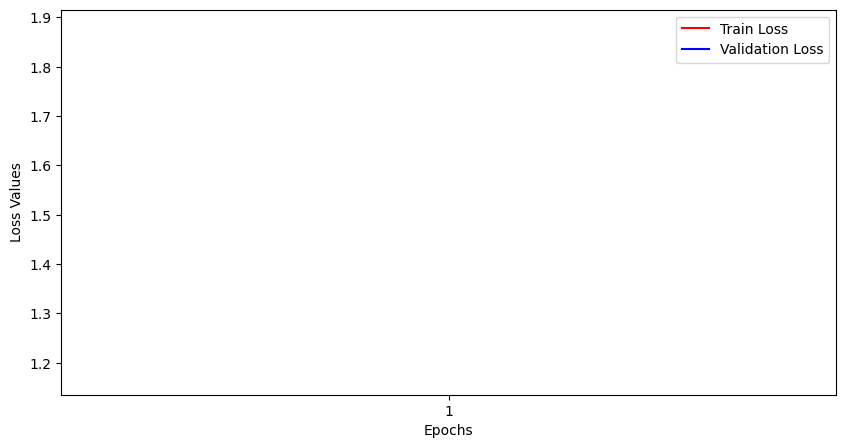

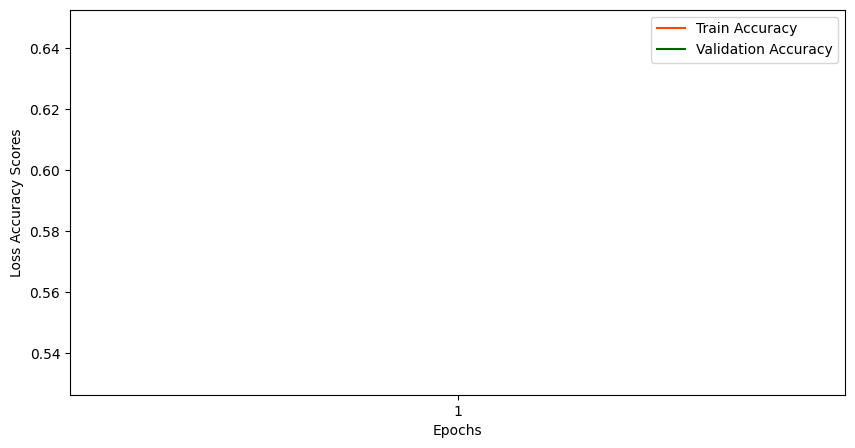

In [20]:
plt.figure(figsize = (10, 5))
plt.plot(train_losses, label = "Train Loss", c = "red")
plt.plot(val_losses, label = "Validation Loss", c = "blue")
plt.xlabel("Epochs"); plt.ylabel("Loss Values")
plt.xticks(ticks = np.arange(len(train_losses)), labels = [i for i in range(1, len(train_losses) + 1)])
plt.legend(); plt.show()

plt.figure(figsize = (10, 5))
plt.plot(train_accs, label = "Train Accuracy", c = "orangered")
plt.plot(val_accs, label = "Validation Accuracy", c = "darkgreen")
plt.xlabel("Epochs"); plt.ylabel("Loss Accuracy Scores")
plt.xticks(ticks = np.arange(len(train_accs)), labels = [i for i in range(1, len(train_accs) + 1)])
plt.legend()
plt.show()

In [21]:
net.load_state_dict(torch.load("./models/model.pth"))
net.eval()
net.to(device)

NeuralNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=59536, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=60, bias=True)
)

In [22]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item() 

print(f'Accuracy of the network on the test images: {(correct / total):.2%}')

Accuracy of the network on the test images: 64.69%
